## Importing Model

`resnet50_2020-07-20` is being used using retinaface (multibox detection model).

In [54]:
%pip install retinaface-pytorch

In [55]:
from matplotlib import pyplot as plt
from retinaface.pre_trained_models import get_model
from retinaface.utils import vis_annotations
import torch

In [56]:
# Device Agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [57]:
import zipfile
from pathlib import Path

zip_path = Path("img-set-2.zip")

# Specify the directory where you want to extract the files
extract_path = Path("")

# Create a ZipFile object and extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Zip file extracted to: {extract_path}")

Zip file extracted to: .


In [58]:
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps


main_path = Path("img-set-2")
all_images = list(main_path.glob("*.png"))

index = 1

img = Image.open(all_images[index])
img = ImageOps.exif_transpose(img)   # to negate auto rotation using meta data
img_array = np.array(img)


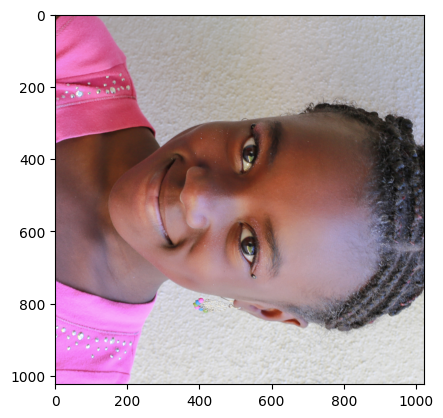

In [59]:
plt.imshow(img_array)

In [60]:
model = get_model("resnet50_2020-07-20", max_size=2048, device=device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/hub.py:870: FutureWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  return _legacy_zip_load(cached_file, model_dir, map_location, weights_only)


## Added Padding to improve accuracy

`single shot multi box detection` models struggle with fully zoomed images and it was also
observed during testing so padding was added to increase accuracy and reliability.

In [61]:
def add_padding(img : Image.Image) -> Image.Image:
    image = np.array(img)

    height = image.shape[0]
    width = image.shape[1]
    new_height = int(1.5 * height)
    new_width = int(1.5 * width)

    y_pad = (new_height - height) // 2
    x_pad = (new_width - width) // 2

    padding = (x_pad, y_pad, x_pad, y_pad)  # 10px left/right, 20px top/bottom
    color = (255, 255, 255)  # White color for padding

    # Add padding
    padded_img = ImageOps.expand(img, border=padding, fill=color)

    return padded_img

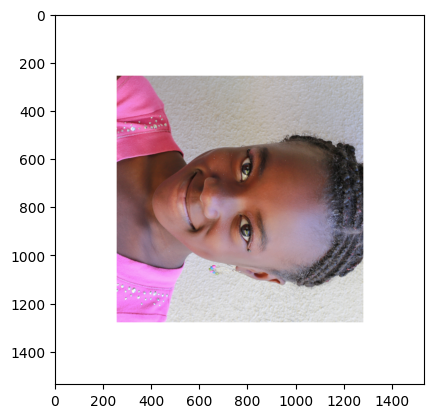

In [62]:
padded_img = add_padding(img)
padded_img_array = np.array(padded_img)

plt.imshow(padded_img_array)

In [63]:
model.eval()

annotation = model.predict_jsons(padded_img_array, confidence_threshold=0.9)
annotation

[{'bbox': [426, 500, 1009, 1037],
  'score': np.float64(0.9998601675033569),
  'landmarks': [[792, 644], [780, 888], [615, 760], [560, 647], [553, 868]]}]

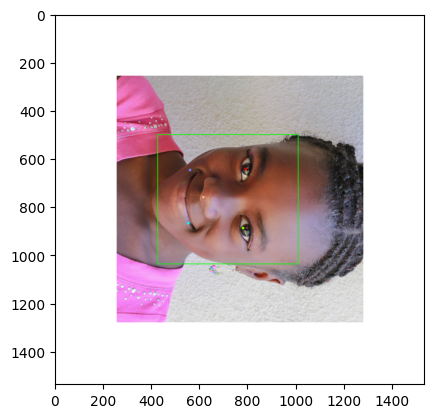

In [64]:
plt.imshow(vis_annotations(padded_img_array, annotation))

## Main Loop

### Function for Finding Angle

`angle` is also mapped to be a multiple of 90 to give desired results.

In [65]:
import numpy as np
import math

def find_angle(points: tuple):
    x1, y1 = points[0]
    x2, y2 = points[1]
    vector = np.array((x2 - x1, y2 - y1))
    mag = math.sqrt((vector ** 2).sum())
    unit_vec = vector / mag

    # Angle with respect to x-axis
    angle_rad = math.acos(unit_vec[0])
    # If y component is negative, adjust angle to (360 - angle)
    if unit_vec[1] < 0:
        angle_rad = 2 * math.pi - angle_rad
    angle_deg = math.degrees(angle_rad)

    rotations = angle_deg / 90

    angle = int(rotations) * 90

    if rotations - int(rotations) > 0.8:
        angle += 90

    return angle


In [66]:
find_angle(annotation[0]['landmarks'])

90

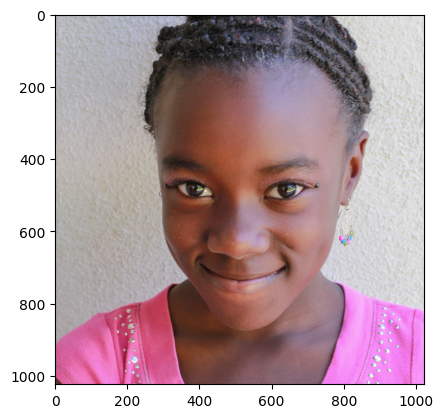

In [67]:
import numpy as np
import PIL

def rotate(image : Image.Image, angle):

    rotated_img = image.rotate(angle, expand = True)
    return rotated_img



bbox = annotation[0]['bbox']  # Example bbox from RetinaFace, etc.
angle = find_angle(annotation[0]['landmarks'])
face_patch = rotate(img, angle)

plt.imshow(face_patch)

## Processing and Saving Outputs



In [68]:
from tqdm import tqdm
import pandas as pd
import timeit

output_path = Path("rotated_images")
output_path.mkdir(exist_ok=True)

df = pd.DataFrame(columns=["image_name", "face_angle", "inference time"])

for i, img_pth in enumerate(tqdm(all_images)):
    plt.figure(figsize=(15, 7))

    t1 = timeit.default_timer()

    input_img = Image.open(img_pth)
    input_img = ImageOps.exif_transpose(input_img)   # to negate auto rotation using meta data

    padded_img = add_padding(input_img)
    padded_img_array = np.array(padded_img)

    out_annotation = model.predict_jsons(padded_img_array, confidence_threshold=0.9)

    points = out_annotation[0]["landmarks"]

    angle = find_angle(points)

    rotated_img = rotate(input_img, angle)

    plt.subplot(1, 2, 1)
    plt.imshow(input_img)
    plt.axis(False)
    plt.title("Original")

    plt.subplot(1, 2, 2)
    plt.imshow(rotated_img)
    plt.axis(False)
    plt.title("Adjusted")

    plt.savefig(output_path / f"{img_pth.stem}.png")

    t2 = timeit.default_timer()
    dtime = t2-t1

    df.loc[len(df)] = [img_pth.name, angle, dtime]

    plt.close()

100%|██████████| 59/59 [00:53<00:00,  1.10it/s]


In [69]:
df.to_csv("problem2_b.csv")